In [2]:
import netCDF4 as nc
from netCDF4 import num2date,date2index
import datetime
import csv
import numpy as np
import pandas as pd
import xarray as xr
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Dense
from keras.models import Model
from sklearn.preprocessing import normalize
import seaborn as sns
from sklearn.feature_selection import mutual_info_regression
from tensorflow.keras.initializers import glorot_uniform
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

2024-01-09 12:41:05.572624: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-09 12:41:05.573769: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-09 12:41:05.591750: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-09 12:41:05.591767: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-09 12:41:05.592276: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [3]:
data = nc.Dataset('AirT.nc')

In [4]:
data

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    CDI: Climate Data Interface version 1.9.10 (https://mpimet.mpg.de/cdi)
    Conventions: COARDS
    description: Data is from NMC initialized reanalysis
(4x/day).  It consists of T62 variables interpolated to
pressure surfaces from model (sigma) surfaces.
    platform: Model
    NCO: 20121012
    title: monthly mean air.2m from the NCEP Reanalysis
    dataset_title: NCEP-NCAR Reanalysis 1
    References: http://www.psl.noaa.gov/data/gridded/data.ncep.reanalysis.derived.html
    CDO: Climate Data Operators version 1.9.10 (https://mpimet.mpg.de/cdo)
    history: 16-Jun-2023 03:11:00 Subset NOAA/PSL  
    dimensions(sizes): time(708), lon(192), lat(94)
    variables(dimensions): float64 time(time), float32 lon(lon), float32 lat(lat), float32 air(time, lat, lon)
    groups: 

In [5]:
air = data.variables['air']
print(air)

<class 'netCDF4._netCDF4.Variable'>
float32 air(time, lat, lon)
    long_name: Monthly Mean of Air Temperature
    units: degK
    CDI_grid_type: gaussian
    CDI_grid_num_LPE: 47
    _FillValue: -9.96921e+36
    missing_value: -9.96921e+36
    precision: 2
    least_significant_digit: 1
    GRIB_id: 11
    GRIB_name: TMP
    var_desc: Air temperature
    level_desc: 2 m
    statistic: Mean
    parent_stat: Individual Obs
    dataset: NCEP Reanalysis Derived Products
    actual_range: [187.4545  314.80725]
unlimited dimensions: time
current shape = (708, 94, 192)
filling off


In [6]:
latitude = data.variables['lat']
print(latitude)

<class 'netCDF4._netCDF4.Variable'>
float32 lat(lat)
    standard_name: latitude
    long_name: Latitude
    units: degrees_north
    axis: Y
    actual_range: [ 88.542 -88.542]
unlimited dimensions: 
current shape = (94,)
filling off


In [7]:
latitude[:]

masked_array(data=[ 88.542   ,  86.6531  ,  84.7532  ,  82.8508  ,
                    80.9473  ,  79.0435  ,  77.1394  ,  75.2351  ,
                    73.3307  ,  71.4262  ,  69.5217  ,  67.6171  ,
                    65.7125  ,  63.8079  ,  61.9033  ,  59.9986  ,
                    58.0939  ,  56.1893  ,  54.2846  ,  52.3799  ,
                    50.4752  ,  48.5705  ,  46.6658  ,  44.7611  ,
                    42.8564  ,  40.9517  ,  39.047   ,  37.1422  ,
                    35.2375  ,  33.3328  ,  31.4281  ,  29.5234  ,
                    27.6186  ,  25.7139  ,  23.8092  ,  21.9044  ,
                    19.9997  ,  18.095   ,  16.1902  ,  14.2855  ,
                    12.3808  ,  10.47604 ,   8.57131 ,   6.66657 ,
                     4.76184 ,   2.8571  ,   0.952368,  -0.952368,
                    -2.8571  ,  -4.76184 ,  -6.66657 ,  -8.57131 ,
                   -10.47604 , -12.3808  , -14.2855  , -16.1902  ,
                   -18.095   , -19.9997  , -21.9044  , -23.809

In [11]:
longitude = data.variables['lon']
print(longitude)

<class 'netCDF4._netCDF4.Variable'>
float32 lon(lon)
    standard_name: longitude
    long_name: Longitude
    units: degrees_east
    axis: X
    actual_range: [  0.    358.125]
unlimited dimensions: 
current shape = (192,)
filling off


In [12]:
longitude[:]

masked_array(data=[  0.   ,   1.875,   3.75 ,   5.625,   7.5  ,   9.375,
                    11.25 ,  13.125,  15.   ,  16.875,  18.75 ,  20.625,
                    22.5  ,  24.375,  26.25 ,  28.125,  30.   ,  31.875,
                    33.75 ,  35.625,  37.5  ,  39.375,  41.25 ,  43.125,
                    45.   ,  46.875,  48.75 ,  50.625,  52.5  ,  54.375,
                    56.25 ,  58.125,  60.   ,  61.875,  63.75 ,  65.625,
                    67.5  ,  69.375,  71.25 ,  73.125,  75.   ,  76.875,
                    78.75 ,  80.625,  82.5  ,  84.375,  86.25 ,  88.125,
                    90.   ,  91.875,  93.75 ,  95.625,  97.5  ,  99.375,
                   101.25 , 103.125, 105.   , 106.875, 108.75 , 110.625,
                   112.5  , 114.375, 116.25 , 118.125, 120.   , 121.875,
                   123.75 , 125.625, 127.5  , 129.375, 131.25 , 133.125,
                   135.   , 136.875, 138.75 , 140.625, 142.5  , 144.375,
                   146.25 , 148.125, 150.   , 151.8

In [9]:
time = data.variables['time']
time_ = time[:]
time_units = time.units
time_calendar = time.calendar
time_dates = num2date(time_, units=time_units, calendar=time_calendar)
start_date = datetime.datetime(1958, 1, 1)
start_index = date2index(start_date, time, select='nearest')
air_subset = data['air'][start_index:, :, :]

In [10]:
data_ = np.array(air_subset)
data_[data_ == -9.96921e+36] = 0

In [11]:
for date in time_dates:
    print(date)

1958-01-01 00:00:00
1958-02-01 00:00:00
1958-03-01 00:00:00
1958-04-01 00:00:00
1958-05-01 00:00:00
1958-06-01 00:00:00
1958-07-01 00:00:00
1958-08-01 00:00:00
1958-09-01 00:00:00
1958-10-01 00:00:00
1958-11-01 00:00:00
1958-12-01 00:00:00
1959-01-01 00:00:00
1959-02-01 00:00:00
1959-03-01 00:00:00
1959-04-01 00:00:00
1959-05-01 00:00:00
1959-06-01 00:00:00
1959-07-01 00:00:00
1959-08-01 00:00:00
1959-09-01 00:00:00
1959-10-01 00:00:00
1959-11-01 00:00:00
1959-12-01 00:00:00
1960-01-01 00:00:00
1960-02-01 00:00:00
1960-03-01 00:00:00
1960-04-01 00:00:00
1960-05-01 00:00:00
1960-06-01 00:00:00
1960-07-01 00:00:00
1960-08-01 00:00:00
1960-09-01 00:00:00
1960-10-01 00:00:00
1960-11-01 00:00:00
1960-12-01 00:00:00
1961-01-01 00:00:00
1961-02-01 00:00:00
1961-03-01 00:00:00
1961-04-01 00:00:00
1961-05-01 00:00:00
1961-06-01 00:00:00
1961-07-01 00:00:00
1961-08-01 00:00:00
1961-09-01 00:00:00
1961-10-01 00:00:00
1961-11-01 00:00:00
1961-12-01 00:00:00
1962-01-01 00:00:00
1962-02-01 00:00:00


In [12]:
data_

array([[[242.67839, 242.67741, 242.65549, ..., 242.74127, 242.71709,
         242.69644],
        [243.68414, 243.68127, 243.67902, ..., 243.6503 , 243.6819 ,
         243.69708],
        [245.25447, 245.32898, 245.41322, ..., 245.10028, 245.16899,
         245.2345 ],
        ...,
        [257.8329 , 258.05096, 258.26257, ..., 257.24097, 257.42807,
         257.6313 ],
        [258.0322 , 258.11777, 258.2148 , ..., 257.84323, 257.89645,
         257.9648 ],
        [257.93512, 257.9254 , 257.91937, ..., 257.96323, 257.95227,
         257.9429 ]],

       [[237.96216, 237.95569, 237.9528 , ..., 237.955  , 237.94217,
         237.96141],
        [237.40498, 237.54497, 237.67213, ..., 236.95248, 237.09282,
         237.2539 ],
        [238.65605, 238.98608, 239.29248, ..., 237.69926, 238.01817,
         238.34322],
        ...,
        [234.59033, 234.6957 , 234.79604, ..., 234.65785, 234.5586 ,
         234.54285],
        [235.72789, 235.5986 , 235.48856, ..., 236.20923, 236.02783,
   

In [13]:
np.max(data_)

313.74673

In [14]:
np.min(data_)

187.4545

In [15]:
data_.shape

(708, 94, 192)

In [16]:
len(data_)

708

In [17]:
num_years = data_.shape[0] // 12
num_months = data_.shape[0] // num_years

In [18]:
num_years

59

In [19]:
num_months

12

In [20]:
data_reshaped = np.reshape(data_, (len(data_) // 12, 12, data_.shape[1],data_.shape[2]))

In [8]:
lat_indices = []
for start_value in np.arange(90, -90, -10):  # Changed step to -10 for descending order
    end_value = start_value - 10  # Adjusted end_value calculation

    # Get indices within the range
    range_indices = np.where((latitude <= start_value) & (latitude >= end_value))[0]

    if len(range_indices) > 0:  # Check if any values are within the range
        # Get indices of largest and smallest values
        min_index = range_indices[np.argmax(latitude[range_indices])]
        max_index = range_indices[np.argmin(latitude[range_indices])]
        
        lat_indices.append(min_index)
        lat_indices.append(max_index)

        print(f"Range {start_value} to {end_value}: Min index = {min_index}, Max index = {max_index}, Min = {latitude[min_index]}, Max = {latitude[max_index]}")
    else:
        print(f"No values found in range {start_value} to {end_value}")

Range 90 to 80: Min index = 0, Max index = 4, Min = 88.54199981689453, Max = 80.94730377197266
Range 80 to 70: Min index = 5, Max index = 9, Min = 79.04350280761719, Max = 71.42620086669922
Range 70 to 60: Min index = 10, Max index = 14, Min = 69.52169799804688, Max = 61.90330123901367
Range 60 to 50: Min index = 15, Max index = 20, Min = 59.998600006103516, Max = 50.47520065307617
Range 50 to 40: Min index = 21, Max index = 25, Min = 48.570499420166016, Max = 40.951698303222656
Range 40 to 30: Min index = 26, Max index = 30, Min = 39.047000885009766, Max = 31.4281005859375
Range 30 to 20: Min index = 31, Max index = 35, Min = 29.523399353027344, Max = 21.904399871826172
Range 20 to 10: Min index = 36, Max index = 41, Min = 19.99970054626465, Max = 10.47603988647461
Range 10 to 0: Min index = 42, Max index = 46, Min = 8.571310043334961, Max = 0.9523680210113525
Range 0 to -10: Min index = 47, Max index = 51, Min = -0.9523680210113525, Max = -8.571310043334961
Range -10 to -20: Min inde

In [22]:
lat_indices

[0,
 4,
 5,
 9,
 10,
 14,
 15,
 20,
 21,
 25,
 26,
 30,
 31,
 35,
 36,
 41,
 42,
 46,
 47,
 51,
 52,
 57,
 58,
 62,
 63,
 67,
 68,
 72,
 73,
 78,
 79,
 83,
 84,
 88,
 89,
 93]

In [23]:
len(lat_indices)

36

In [13]:
lon_indices = []
for start_value in np.arange(0, 360, 20):  # Changed step to -10 for descending order
    end_value = start_value + 20  # Adjusted end_value calculation

    # Get indices within the range
    range_indices = np.where((longitude >= start_value) & (longitude <= end_value))[0]

    if len(range_indices) > 0:  # Check if any values are within the range
        # Get indices of largest and smallest values
        min_index = range_indices[np.argmin(longitude[range_indices])]
        max_index = range_indices[np.argmax(longitude[range_indices])]
        
        lon_indices.append(min_index)
        lon_indices.append(max_index)

        print(f"Range {start_value} to {end_value}: Min index = {min_index}, Max index = {max_index}, Min = {longitude[min_index]}, Max = {longitude[max_index]}")
    else:
        print(f"No values found in range {start_value} to {end_value}")

Range 0 to 20: Min index = 0, Max index = 10, Min = 0.0, Max = 18.75
Range 20 to 40: Min index = 11, Max index = 21, Min = 20.625, Max = 39.375
Range 40 to 60: Min index = 22, Max index = 32, Min = 41.25, Max = 60.0
Range 60 to 80: Min index = 32, Max index = 42, Min = 60.0, Max = 78.75
Range 80 to 100: Min index = 43, Max index = 53, Min = 80.625, Max = 99.375
Range 100 to 120: Min index = 54, Max index = 64, Min = 101.25, Max = 120.0
Range 120 to 140: Min index = 64, Max index = 74, Min = 120.0, Max = 138.75
Range 140 to 160: Min index = 75, Max index = 85, Min = 140.625, Max = 159.375
Range 160 to 180: Min index = 86, Max index = 96, Min = 161.25, Max = 180.0
Range 180 to 200: Min index = 96, Max index = 106, Min = 180.0, Max = 198.75
Range 200 to 220: Min index = 107, Max index = 117, Min = 200.625, Max = 219.375
Range 220 to 240: Min index = 118, Max index = 128, Min = 221.25, Max = 240.0
Range 240 to 260: Min index = 128, Max index = 138, Min = 240.0, Max = 258.75
Range 260 to 28

In [25]:
lon_indices

[0,
 10,
 11,
 21,
 22,
 31,
 32,
 42,
 43,
 53,
 54,
 63,
 64,
 74,
 75,
 85,
 86,
 95,
 96,
 106,
 107,
 117,
 118,
 127,
 128,
 138,
 139,
 149,
 150,
 159,
 160,
 170,
 171,
 181,
 182,
 191]

In [26]:
len(lon_indices)

36

In [27]:
for lat_idx in range(0, len(lat_indices), 2):
    lat_range_start = lat_indices[lat_idx]
    lat_range_end = lat_indices[lat_idx + 1]
    print(lat_range_start,lat_range_end)

0 4
5 9
10 14
15 20
21 25
26 30
31 35
36 41
42 46
47 51
52 57
58 62
63 67
68 72
73 78
79 83
84 88
89 93


In [28]:
for lon_idx in range(0, len(lon_indices),2):
    lon_range_start = lon_indices[lon_idx]
    lon_range_end = lon_indices[lon_idx + 1]
    print(lon_range_start,lon_range_end)

0 10
11 21
22 31
32 42
43 53
54 63
64 74
75 85
86 95
96 106
107 117
118 127
128 138
139 149
150 159
160 170
171 181
182 191


In [29]:
def coarse_gridding(data, lat_indices, lon_indices):
    coarsed_data = np.zeros((data.shape[0], data.shape[1], len(lat_indices) // 2, len(lon_indices) // 2))
    for lat_idx in range(0, len(lat_indices), 2):
        lat_range_start = lat_indices[lat_idx]
        lat_range_end = lat_indices[lat_idx + 1]
        for lon_idx in range(0, len(lon_indices), 2):
            lon_range_start = lon_indices[lon_idx]
            lon_range_end = lon_indices[lon_idx + 1]
            subset = data[:, :, lat_range_start:lat_range_end, lon_range_start:lon_range_end]
            averaged_value = np.mean(subset, axis=(2, 3))
            coarsed_data[:, :, lat_idx // 2, lon_idx // 2] = averaged_value
    return coarsed_data


In [30]:
 avg = coarse_gridding(data_reshaped,lat_indices,lon_indices)

In [31]:
avg.shape

(59, 12, 18, 18)

In [32]:
avg[1,1,:,1]

array([237.91757202, 260.10202026, 268.48214722, 268.39157104,
       271.36395264, 279.28863525, 283.61322021, 293.53561401,
       296.75665283, 294.19985962, 294.51821899, 296.90673828,
       294.46496582, 284.94174194, 276.02813721, 273.51663208,
       245.37313843, 237.2964325 ])

In [33]:
final= np.reshape(avg, (len(data_) // 12, 12, 324))

In [34]:
final.shape

(59, 12, 324)

In [35]:
np.max(final)

308.5638732910156

In [36]:
np.min(final)

200.49240112304688

In [37]:
ff= final.reshape(324,708)
ff.shape

(324, 708)

In [38]:
def calculate_monthly_anomaliess(data):
    """Calculate monthly anomalies and mean for a given dataset.

    Args:
        data: A multidimensional array with dimensions (years, months, latlon).

    Returns:
        monthly_anomalies: An array with monthly anomalies of the same shape as the input data.
        monthly_mean: A multidimensional array with dimensions (months, latlon) representing the mean for each month.
    """


    anomalies = np.zeros((59,12,324))
    for i in range(data.shape[2]):
        for j in range(data.shape[1]):
            month = data[:, j, i]
            monthly_mean = np.mean(month)
            anomalies[:, j, i] = month - monthly_mean
    return anomalies

def min_max_normalize(data):
    normalized_data = np.zeros((59,12,324))
    for i in range(data.shape[2]):
        for j in range(data.shape[1]):
            month = data[:, j, i]

            # Calculate min and max values for each month
            min_value = np.min(month)
            max_value = np.max(month)

            # Normalize each month value
            normalized_month = (month - min_value) / (max_value - min_value)

            # Store normalized month data
            normalized_data[:, j, i] = normalized_month


    return normalized_data




In [39]:
anomalies = calculate_monthly_anomaliess(final)
anomalies

array([[[ 2.41490018,  1.50256813,  0.62712459, ...,  1.78126655,
          2.92965078,  4.79115011],
        [-2.24119128, -2.01722614, -1.83133943, ..., -2.137281  ,
         -1.61046174, -1.32883673],
        [ 1.82021836,  0.42056223,  0.12525759, ..., -0.20518054,
         -0.18625292, -0.15214616],
        ...,
        [-3.75099492, -3.45784617, -3.56042558, ...,  0.36721647,
         -0.26667527,  0.2699947 ],
        [-1.10312226, -1.41140126, -1.41203748, ..., -1.48686037,
         -1.79768889, -2.18447255],
        [ 0.13856455, -0.88789963, -1.29491153, ..., -2.27713168,
         -1.6681472 , -1.29694897]],

       [[-3.62797702, -3.14806663, -2.68969364, ...,  0.65333686,
          0.78273915,  0.67084982],
        [-3.58243884, -4.887206  , -5.82857759, ..., -1.39149242,
          0.34139678,  1.94789667],
        [-2.71127578, -1.83735708, -1.00383177, ..., -3.12745227,
         -1.54825243, -1.53434831],
        ...,
        [ 1.3275268 ,  1.70829152,  1.9839012 , ..., -

In [40]:
np.max((anomalies))

16.290083287125924

In [41]:
np.min((anomalies))

-16.870114342641017

In [42]:
normalized_data = min_max_normalize(anomalies)

In [43]:
normalized_data

array([[[0.49976925, 0.45891811, 0.41499438, ..., 0.84572753,
         1.        , 1.        ],
        [0.36135539, 0.37756184, 0.38835586, ..., 0.28123542,
         0.13141923, 0.2612389 ],
        [0.57297835, 0.50911313, 0.50982036, ..., 0.40550899,
         0.44986565, 0.51581615],
        ...,
        [0.32112055, 0.3158109 , 0.28665737, ..., 0.56327253,
         0.42453261, 0.48744818],
        [0.29911515, 0.28860338, 0.31026139, ..., 0.26998777,
         0.26912402, 0.22772299],
        [0.46423104, 0.39576132, 0.3209547 , ..., 0.20006698,
         0.27479765, 0.34143807]],

       [[0.26574908, 0.27752908, 0.28221898, ..., 0.62988507,
         0.66045659, 0.55682477],
        [0.29408469, 0.24427041, 0.20011239, ..., 0.36599468,
         0.42705531, 0.65961899],
        [0.33168668, 0.38317782, 0.44194241, ..., 0.16697224,
         0.30811741, 0.36656984],
        ...,
        [0.61016474, 0.59260101, 0.55914562, ..., 0.42927895,
         0.40882087, 0.3019833 ],
        [0.5

In [44]:
normalized_data.shape

(59, 12, 324)

In [45]:
np.max(np.abs(anomalies))

16.870114342641017

In [46]:
num_positive_values = np.sum(anomalies > 0)

# Find the number of negative values
num_negative_values = np.sum(anomalies < 0)

# Find the number of zero values (optional)
num_zero_values = np.sum(anomalies == 0)

print("Number of positive values:", num_positive_values)
print("Number of negative values:", num_negative_values)
print("Number of zero values:", num_zero_values)

Number of positive values: 114794
Number of negative values: 114598
Number of zero values: 0


In [47]:
anomalies.shape

(59, 12, 324)

In [48]:
tf.random.set_seed(12345)

In [49]:
input_dim = 324
hidden_dim = 65
input_layer = Input(shape = (input_dim,))
hidden_layer = Dense(hidden_dim,activation='tanh')(input_layer)
output_layer = Dense(input_dim,activation='linear')(hidden_layer)

2024-01-08 11:31:51.094738: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-08 11:31:51.095038: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [50]:
input_data = normalized_data.reshape(-1, input_dim)
input_data.shape

(708, 324)

In [51]:
input_data

array([[0.49976925, 0.45891811, 0.41499438, ..., 0.84572753, 1.        ,
        1.        ],
       [0.36135539, 0.37756184, 0.38835586, ..., 0.28123542, 0.13141923,
        0.2612389 ],
       [0.57297835, 0.50911313, 0.50982036, ..., 0.40550899, 0.44986565,
        0.51581615],
       ...,
       [0.96640819, 0.92948788, 0.84642544, ..., 0.4996632 , 0.53602717,
        0.69165612],
       [1.        , 1.        , 1.        , ..., 1.        , 0.91804831,
        0.84808065],
       [0.95562735, 1.        , 1.        , ..., 0.78238981, 0.68243643,
        0.54931417]])

In [52]:
autoencoder = Model(inputs=input_layer, outputs=output_layer)

In [53]:
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

In [54]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 324)]             0         
                                                                 
 dense (Dense)               (None, 65)                21125     
                                                                 
 dense_1 (Dense)             (None, 324)               21384     
                                                                 
Total params: 42509 (166.05 KB)
Trainable params: 42509 (166.05 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [55]:
autoencoder.fit(input_data, input_data, epochs=10
                , batch_size=8)

Epoch 1/10
89/89 [==============================] - 0s 480us/step - loss: 0.0830
Epoch 2/10
89/89 [==============================] - 0s 423us/step - loss: 0.0470
Epoch 3/10
89/89 [==============================] - 0s 724us/step - loss: 0.0424
Epoch 4/10
89/89 [==============================] - 0s 502us/step - loss: 0.0380
Epoch 5/10
89/89 [==============================] - 0s 468us/step - loss: 0.0343
Epoch 6/10
89/89 [==============================] - 0s 524us/step - loss: 0.0314
Epoch 7/10
89/89 [==============================] - 0s 406us/step - loss: 0.0289
Epoch 8/10
89/89 [==============================] - 0s 386us/step - loss: 0.0270
Epoch 9/10
89/89 [==============================] - 0s 379us/step - loss: 0.0252
Epoch 10/10
89/89 [==============================] - 0s 406us/step - loss: 0.0235


In [56]:
encoded_data = autoencoder.predict(input_data)

23/23 [==============================] - 0s 345us/step


In [57]:
encoded_data.shape

(708, 324)

In [58]:
decoded_data = autoencoder.predict(encoded_data)

23/23 [==============================] - 0s 305us/step


In [59]:
decoded_data.shape

(708, 324)

In [60]:
weights = autoencoder.get_weights()[0]# Get the weights of the first layer (between input and hidden)
weights

array([[-0.04999762,  0.12823232, -0.1270871 , ..., -0.10265176,
         0.07772346,  0.01338882],
       [-0.07841261,  0.08159383,  0.0037718 , ..., -0.07276841,
        -0.08670846,  0.0368377 ],
       [-0.10614469,  0.01184505,  0.1109589 , ...,  0.0297477 ,
         0.10768261, -0.09830168],
       ...,
       [ 0.10124592, -0.09266294,  0.08847643, ..., -0.05129695,
         0.13952896, -0.10971797],
       [-0.0307859 , -0.09300245,  0.00054811, ..., -0.00765838,
         0.01690206,  0.05600972],
       [ 0.07837302,  0.04202774,  0.10874564, ..., -0.0495272 ,
        -0.00963075, -0.02623366]], dtype=float32)

In [61]:
np.save('weights.npy', weights)

In [62]:
weights = np.load('weights.npy')

In [63]:
weights

array([[-0.04999762,  0.12823232, -0.1270871 , ..., -0.10265176,
         0.07772346,  0.01338882],
       [-0.07841261,  0.08159383,  0.0037718 , ..., -0.07276841,
        -0.08670846,  0.0368377 ],
       [-0.10614469,  0.01184505,  0.1109589 , ...,  0.0297477 ,
         0.10768261, -0.09830168],
       ...,
       [ 0.10124592, -0.09266294,  0.08847643, ..., -0.05129695,
         0.13952896, -0.10971797],
       [-0.0307859 , -0.09300245,  0.00054811, ..., -0.00765838,
         0.01690206,  0.05600972],
       [ 0.07837302,  0.04202774,  0.10874564, ..., -0.0495272 ,
        -0.00963075, -0.02623366]], dtype=float32)

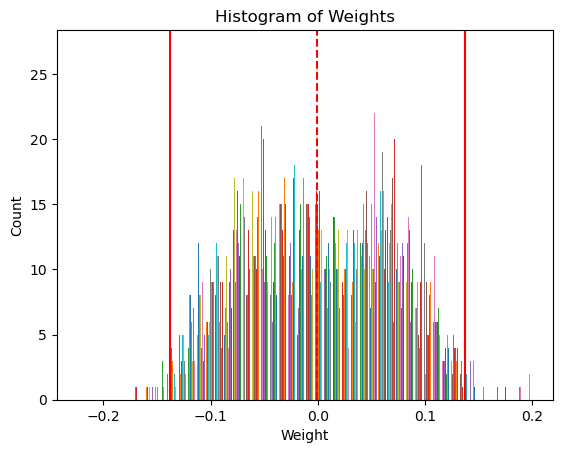

In [64]:
import matplotlib.pyplot as plt
# Calculate the mean and standard deviation of the weights.
mean = np.mean(weights)
sigma = np.std(weights)

# Plot a histogram of the weights.
plt.hist(weights, bins=50)
plt.axvline(mean, color='red', linestyle='dashed')
plt.axvline(mean + 2*sigma, color='red')
plt.axvline(mean - 2*sigma, color='red')
plt.title('Histogram of Weights')
plt.xlabel('Weight')
plt.ylabel('Count')
plt.show()

In [65]:
weights.shape

(324, 65)

In [169]:
def Tweights(weight):
    num = []

    for i in range(weight.shape[1]):
        weight_mean = np.mean(weight[:, i])
        weight_std = np.std(weight[:, i])
        threshold_upper = weight_mean + 1.5 * weight_std
        threshold_lower = weight_mean - 1.5 * weight_std
        nodes_with_weight_above_upper_threshold = np.sum(weight[:, i] > threshold_upper)
        nodes_with_weight_below_lower_threshold = np.sum(weight[:, i] < threshold_lower)
        ten_percent_nodes = int(0.1 * weight.shape[0])

        if nodes_with_weight_above_upper_threshold + nodes_with_weight_below_lower_threshold > ten_percent_nodes:
            num.append(nodes_with_weight_above_upper_threshold + nodes_with_weight_below_lower_threshold)
            print(i, nodes_with_weight_above_upper_threshold, threshold_upper, nodes_with_weight_below_lower_threshold, threshold_lower)

    return num




In [170]:
we = Tweights(weights)
we

1 14 0.10932551093865187 20 -0.11084899238776416
2 17 0.10844395032618195 18 -0.10538277754094452
4 18 0.10469040288589895 19 -0.11042783842422069
5 17 0.1088666718453169 17 -0.1134639222174883
7 14 0.11010346235707402 19 -0.10542383370921016
10 19 0.10337058361619711 14 -0.10858126822859049
13 14 0.10279857972636819 21 -0.10846650740131736
14 23 0.10957098278449849 18 -0.11075417724205182
16 19 0.11171682630665601 15 -0.10734173501841725
17 18 0.10015723295509815 15 -0.1125724595040083
19 10 0.11887144325301052 23 -0.10585525752976538
22 16 0.10837776211556048 17 -0.1062900826567784
24 20 0.10359042290365324 19 -0.10169128772104159
26 15 0.10873239925131202 19 -0.10322360107675195
27 24 0.11415571783436462 13 -0.11396425153361633
29 20 0.10417116302996875 18 -0.1110775886103511
33 17 0.10758522567339242 17 -0.11043721619062126
34 17 0.10344300521537662 17 -0.11261422382667662
35 21 0.1024490092881024 13 -0.10917101157829166
36 14 0.11132901133969426 22 -0.09848038731142879
39 16 0.110

[34,
 35,
 37,
 34,
 33,
 33,
 35,
 41,
 34,
 33,
 33,
 33,
 39,
 34,
 37,
 38,
 34,
 34,
 34,
 36,
 34,
 36,
 38,
 34,
 36,
 35,
 35,
 34,
 33,
 33,
 34]

In [171]:
len(we)

31

In [124]:
pred = np.zeros((65,708))
for i in range(weights.shape[1]):
    weight_mean = np.mean(weights[:,i])
    weight_std = np.std(weights[:,i])
    threshold_upper = weight_mean + 1.5 * weight_std
    threshold_lower = weight_mean - 1.5 * weight_std
    nodes_with_weight_above_upper_threshold = np.sum(weights[:, i] > threshold_upper)
    nodes_with_weight_below_lower_threshold = np.sum(weights[:, i] < threshold_lower)
    ten_percent_nodes = int(0.1 * weights.shape[0])
    if (nodes_with_weight_above_upper_threshold + nodes_with_weight_below_lower_threshold) > ten_percent_nodes:
        for h in range(input_data.shape[0]): 
            pred_i = 0
            for j in range(weights.shape[0]):
                weight_value = weights[j,i]
                if weight_value > threshold_upper or weight_value < threshold_lower:
                    pp = np.sum(weight_value*input_data[h,j])
                    pred_i += pp
                    pred[i,h] = pred_i
                

print(pred)

[[-0.08850864 -0.19170158 -0.01527317 ... -0.39451575 -0.28980427
  -0.07351205]
 [-0.07063766 -0.32256016 -0.16533991 ... -0.22936097  0.01647162
  -0.14019292]
 [ 0.12870722  0.09829484  0.06023405 ... -0.02136029  0.14787014
   0.07569602]
 ...
 [-0.25821814 -0.16941516 -0.10367726 ...  0.16469808  0.08501196
  -0.09451046]
 [-0.05700311 -0.33706079  0.02749203 ... -0.50523133 -0.34367653
  -0.26349243]
 [-0.5155258  -0.20534325 -0.45094437 ... -0.57235722 -0.9561233
  -0.78305737]]


In [125]:
weight_value

-0.026233664

In [126]:
number_of_zeros = np.count_nonzero( pred == 0)

In [127]:
number_of_zeros

0

In [128]:
pred.shape

(65, 708)

In [129]:
predd = pred[12,:].reshape(59,12)
predd

array([[-6.59407229e-02, -4.76518451e-02, -2.71660553e-01,
        -4.15864796e-01, -2.82359731e-02, -4.60422291e-02,
        -3.19626107e-01, -4.25307604e-01, -8.87334509e-02,
        -3.12704459e-02, -1.79009939e-01, -1.30859948e-01],
       [-2.46655190e-01,  8.80193668e-02, -1.08206172e-01,
        -4.42289673e-01, -3.36414022e-01, -2.56429573e-01,
        -2.34898702e-01, -3.70919415e-01, -3.83713152e-01,
        -1.41513536e-01, -2.95477726e-01, -2.17576082e-02],
       [-3.79045220e-01, -2.57318329e-01, -1.44039503e-01,
        -3.48633992e-01, -1.18556793e-01, -2.34808383e-01,
        -3.58248159e-01, -1.53746568e-01, -3.52432885e-01,
        -3.69331285e-01, -6.98558292e-02, -3.76438584e-01],
       [-2.47276294e-01,  1.35873984e-01,  1.25578388e-01,
        -1.34200253e-01, -1.20327757e-01, -4.92080854e-01,
        -3.09897023e-01, -3.04358030e-01, -1.34215172e-01,
        -2.48440677e-01, -3.23821503e-01, -2.37001705e-01],
       [-1.11282869e-01, -1.71702721e-01, -6.9536271

In [130]:
df = pd.read_csv("enso_index.csv")
df

,year,january,february,march,april,may,june,july,august,september,october,november,december,avg
0,1958,1.54,1.40,0.99,0.31,0.32,0.30,0.04,0.24,-0.31,-0.03,0.05,0.30,0.0675
1,1959,0.43,0.50,0.26,0.27,-0.01,-0.33,-0.28,-0.41,-0.53,0.11,-0.17,-0.05,-0.3875
2,1960,0.02,-0.24,-0.08,0.01,0.05,-0.20,-0.25,0.00,0.03,-0.07,-0.38,0.02,-0.1050
3,1961,-0.15,0.04,-0.10,0.13,-0.01,0.10,-0.32,-0.25,-0.52,-0.71,-0.19,-0.29,-0.2475
4,1962,-0.25,-0.16,-0.41,-0.32,-0.42,-0.22,-0.30,-0.13,-0.56,-0.33,-0.43,-0.49,-0.3025
5,1963,-0.32,-0.26,-0.06,-0.06,0.00,0.12,0.72,0.90,0.65,0.84,0.75,1.05,0.5975
6,1964,0.76,0.55,-0.16,-0.53,-0.74,-0.88,-0.65,-0.76,-0.93,-1.00,-1.10,-1.07,-0.8050
7,1965,-0.57,-0.36,-0.34,-0.09,0.19,0.45,0.81,1.25,1.26,1.61,1.54,1.45,0.9425
8,1966,1.13,0.83,0.83,0.54,-0.06,0.14,0.23,-0.10,-0.05,-0.05,-0.37,-0.26,0.0550
9,1967,-0.55,-0.56,-0.47,-0.53,-0.24,-0.12,-0.10,-0.31,-0.59,-0.38,-0.34,-0.35,-0.2800


In [131]:
pred_pres = pred[12,:].reshape(59,12)
years = pd.date_range(start='1958', end='2016', freq='YS').year
months = pd.date_range(start='1975-01', periods=12, freq='MS').strftime('%B')
df_pres = pd.DataFrame(pred_pres, index=years, columns=months)
df_pres = df_pres.reset_index()
df_pres['enso_avg'] = df['avg'].copy()
df_pres.loc[-1] = [1957,0,0,0,0,0, df_pres['June'][0],df_pres['July'][0],df_pres['August'][0], df_pres['September'][0],df_pres['October'][0],df_pres['November'][0],df_pres['December'][0],df_pres['enso_avg'][0]]
df_pres.index = df_pres.index + 1  # shifting index
df_pres = df_pres.sort_index() 
df_pres= df_pres.drop('index',axis=1)
df_6 = df_pres.iloc[1:, :5]
df_6 = df_6.reset_index()
df_12 = df_pres.iloc[0:-1, 5:12]
df_12 = df_12.reset_index()
df_13 = df_pres.iloc[1:, [12]]
df_13 = df_13.reset_index()
df_last = pd.concat([df_6, df_12, df_13], axis=1)
df_last = df_last.drop('index',axis=1)
correlation = df_last.corr(method='pearson')

In [132]:
df_12

,index,June,July,August,September,October,November,December
0,0,-0.046042,-0.319626,-0.425308,-0.088733,-0.031270,-0.179010,-0.130860
1,1,-0.046042,-0.319626,-0.425308,-0.088733,-0.031270,-0.179010,-0.130860
2,2,-0.256430,-0.234899,-0.370919,-0.383713,-0.141514,-0.295478,-0.021758
3,3,-0.234808,-0.358248,-0.153747,-0.352433,-0.369331,-0.069856,-0.376439
4,4,-0.492081,-0.309897,-0.304358,-0.134215,-0.248441,-0.323822,-0.237002
5,5,-0.301809,-0.166301,-0.155052,-0.148406,-0.263178,-0.667343,-0.537620
6,6,-0.302354,-0.249898,-0.247853,-0.458038,-0.247546,-0.239449,-0.535528
7,7,-0.237289,-0.209669,-0.358084,-0.019491,-0.230755,-0.547178,-0.319485
8,8,-0.339898,-0.222199,-0.340532,-0.308764,-0.277210,-0.256824,-0.073408
9,9,-0.249734,-0.129500,-0.338739,-0.142640,-0.136004,-0.331646,-0.259079


In [133]:
df_pres

,January,February,March,April,May,June,July,August,September,October,November,December,enso_avg
0,0.000000,0.000000,0.000000,0.000000,0.000000,-0.046042,-0.319626,-0.425308,-0.088733,-0.031270,-0.179010,-0.130860,0.0675
1,-0.065941,-0.047652,-0.271661,-0.415865,-0.028236,-0.046042,-0.319626,-0.425308,-0.088733,-0.031270,-0.179010,-0.130860,0.0675
2,-0.246655,0.088019,-0.108206,-0.442290,-0.336414,-0.256430,-0.234899,-0.370919,-0.383713,-0.141514,-0.295478,-0.021758,-0.3875
3,-0.379045,-0.257318,-0.144040,-0.348634,-0.118557,-0.234808,-0.358248,-0.153747,-0.352433,-0.369331,-0.069856,-0.376439,-0.1050
4,-0.247276,0.135874,0.125578,-0.134200,-0.120328,-0.492081,-0.309897,-0.304358,-0.134215,-0.248441,-0.323822,-0.237002,-0.2475
5,-0.111283,-0.171703,-0.695363,-0.350103,-0.303597,-0.301809,-0.166301,-0.155052,-0.148406,-0.263178,-0.667343,-0.537620,-0.3025
6,-0.370166,-0.499476,-0.197214,-0.407319,-0.387138,-0.302354,-0.249898,-0.247853,-0.458038,-0.247546,-0.239449,-0.535528,0.5975
7,-0.292810,0.020312,-0.141914,-0.163145,0.089776,-0.237289,-0.209669,-0.358084,-0.019491,-0.230755,-0.547178,-0.319485,-0.8050
8,-0.285410,-0.458362,-0.199060,-0.301394,-0.240515,-0.339898,-0.222199,-0.340532,-0.308764,-0.277210,-0.256824,-0.073408,0.9425
9,-0.017008,0.037362,-0.285255,-0.163249,-0.142426,-0.249734,-0.129500,-0.338739,-0.142640,-0.136004,-0.331646,-0.259079,0.0550


In [134]:
df_last

,January,February,March,April,May,June,July,August,September,October,November,December,enso_avg
0,-0.065941,-0.047652,-0.271661,-0.415865,-0.028236,-0.046042,-0.319626,-0.425308,-0.088733,-0.031270,-0.179010,-0.130860,0.0675
1,-0.246655,0.088019,-0.108206,-0.442290,-0.336414,-0.046042,-0.319626,-0.425308,-0.088733,-0.031270,-0.179010,-0.130860,-0.3875
2,-0.379045,-0.257318,-0.144040,-0.348634,-0.118557,-0.256430,-0.234899,-0.370919,-0.383713,-0.141514,-0.295478,-0.021758,-0.1050
3,-0.247276,0.135874,0.125578,-0.134200,-0.120328,-0.234808,-0.358248,-0.153747,-0.352433,-0.369331,-0.069856,-0.376439,-0.2475
4,-0.111283,-0.171703,-0.695363,-0.350103,-0.303597,-0.492081,-0.309897,-0.304358,-0.134215,-0.248441,-0.323822,-0.237002,-0.3025
5,-0.370166,-0.499476,-0.197214,-0.407319,-0.387138,-0.301809,-0.166301,-0.155052,-0.148406,-0.263178,-0.667343,-0.537620,0.5975
6,-0.292810,0.020312,-0.141914,-0.163145,0.089776,-0.302354,-0.249898,-0.247853,-0.458038,-0.247546,-0.239449,-0.535528,-0.8050
7,-0.285410,-0.458362,-0.199060,-0.301394,-0.240515,-0.237289,-0.209669,-0.358084,-0.019491,-0.230755,-0.547178,-0.319485,0.9425
8,-0.017008,0.037362,-0.285255,-0.163249,-0.142426,-0.339898,-0.222199,-0.340532,-0.308764,-0.277210,-0.256824,-0.073408,0.0550
9,-0.251336,-0.073522,0.031498,-0.299660,-0.184816,-0.249734,-0.129500,-0.338739,-0.142640,-0.136004,-0.331646,-0.259079,-0.2800


In [135]:
correlation

,January,February,March,April,May,June,July,August,September,October,November,December,enso_avg
January,1.000000,0.406370,0.186327,0.251940,-0.003423,0.054908,0.133912,0.173152,0.339369,0.130729,0.210784,0.417053,-0.128906
February,0.406370,1.000000,0.426458,0.287607,0.097291,-0.113738,-0.002761,-0.165519,-0.006346,0.107126,0.209742,0.250649,-0.194125
March,0.186327,0.426458,1.000000,0.553424,0.241312,0.232870,0.193797,0.131848,0.150088,0.302363,0.298095,0.261344,0.135478
April,0.251940,0.287607,0.553424,1.000000,0.442719,0.257528,0.387703,0.253911,0.071265,0.332729,0.280814,0.277654,0.263900
May,-0.003423,0.097291,0.241312,0.442719,1.000000,-0.019396,0.048536,-0.019757,-0.115043,-0.018439,-0.028822,-0.083050,0.321195
June,0.054908,-0.113738,0.232870,0.257528,-0.019396,1.000000,0.584093,0.292862,0.210892,0.405530,0.575058,0.311197,-0.024721
July,0.133912,-0.002761,0.193797,0.387703,0.048536,0.584093,1.000000,0.406886,0.282993,0.440704,0.540151,0.265687,-0.029071
August,0.173152,-0.165519,0.131848,0.253911,-0.019757,0.292862,0.406886,1.000000,0.342423,0.220189,0.385374,0.177742,-0.176088
September,0.339369,-0.006346,0.150088,0.071265,-0.115043,0.210892,0.282993,0.342423,1.000000,0.525581,0.295091,0.242926,-0.136676
October,0.130729,0.107126,0.302363,0.332729,-0.018439,0.405530,0.440704,0.220189,0.525581,1.000000,0.459974,0.371479,0.081791


In [136]:
def potential_predictors_new(data):
    global top_correlation
    top_correlation = []
    top_preds = pd.DataFrame()
    for i in range(65):
        pred_pres = data[i,:].reshape(59,12)
        # Create year and month ranges
        years = pd.date_range(start='1958', end='2016', freq='YS').year
        months = pd.date_range(start='1975-01', periods=12, freq='MS').strftime('%B')
        # Create the DataFrame
        
        df_pres = pd.DataFrame(pred_pres, index=years, columns=months)
        df_pres = df_pres.reset_index()
        df_pres['enso_avg'] = df['avg'].copy()
        df_pres.loc[-1] = [1957,0,0,0,0,0, df_pres['June'][0],df_pres['July'][0],df_pres['August'][0], df_pres['September'][0],df_pres['October'][0],df_pres['November'][0],df_pres['December'][0],df_pres['enso_avg'][0]]
        df_pres.index = df_pres.index + 1  # shifting index
        df_pres = df_pres.sort_index() 
        df_pres= df_pres.drop('index',axis=1)
        df_6 = df_pres.iloc[1:, :5]
        df_6 = df_6.reset_index()
        df_12 = df_pres.iloc[0:-1, 5:12]
        df_12 = df_12.reset_index()
        df_13 = df_pres.iloc[1:, [12]]
        df_13 = df_13.reset_index()
        df_last = pd.concat([df_6, df_12, df_13], axis=1)
        df_last = df_last.drop('index',axis=1)
        correlation = df_last.corr(method='pearson')
        second_max_value = correlation['enso_avg'].sort_values(ascending=False)[1]
        negative_minimum = correlation['enso_avg'].sort_values(ascending=False)[-1]
        second_max_index = correlation['enso_avg'].sort_values(ascending=False).index[1]
        negative_min_index = correlation['enso_avg'].sort_values(ascending=False).index[-1]
        if abs(second_max_value) > abs(negative_minimum):
            highest_correlation = second_max_value
            highest_correlation_index = second_max_index
            
        else:
            highest_correlation = negative_minimum
            highest_correlation_index = negative_min_index
            
        column_name = highest_correlation_index
        suffix_index = 1
        while column_name in top_preds.columns:
            suffix_index += 1
            column_name = f"{highest_correlation_index}_{suffix_index}"
        
        top_preds[column_name] = df_last[highest_correlation_index]
        top_correlation.append((i, highest_correlation,column_name , abs(highest_correlation)))
        print(i,highest_correlation,column_name,abs(highest_correlation))
        result_df = pd.DataFrame(top_correlation, columns=['Iteration', 'Correlation', 'Column_Name', 'Absolute_Correlation'])
    return top_preds,result_df
        
    

In [137]:
top_predp,resultp = potential_predictors_new(pred)

0 0.19267261504609948 December 0.19267261504609948
1 0.3598660923484432 December_2 0.3598660923484432
2 0.21275923579264255 December_3 0.21275923579264255
3 -0.3117666195993045 September 0.3117666195993045
4 0.26075106593977754 February 0.26075106593977754
5 -0.329332769175835 November 0.329332769175835
6 0.4160369785294154 May 0.4160369785294154
7 -0.311852970486138 May_2 0.311852970486138
8 -0.16059166230504465 January 0.16059166230504465
9 0.2580358151163868 January_2 0.2580358151163868
10 -0.21529309876978828 April 0.21529309876978828
11 0.23971669929374056 August 0.23971669929374056
12 0.3211951329938001 May_3 0.3211951329938001
13 0.35684805743520037 February_2 0.35684805743520037
14 0.24741243267426213 February_3 0.24741243267426213
15 -0.2972277333414793 January_3 0.2972277333414793
16 -0.28680993548712275 January_4 0.28680993548712275
17 0.26048292884028695 August_2 0.26048292884028695
18 0.21758786687830328 August_3 0.21758786687830328
19 -0.4079323377797767 March 0.407932337

In [138]:
resultp = resultp.sort_values(by='Absolute_Correlation', ascending=False)
resultp

,Iteration,Correlation,Column_Name,Absolute_Correlation
47,47,-0.510838,May_8,0.510838
56,56,0.450891,May_10,0.450891
22,22,-0.424068,May_4,0.424068
28,28,-0.416282,November_2,0.416282
6,6,0.416037,May,0.416037
...,...,...,...,...
34,34,0.188905,October,0.188905
59,59,0.184199,April_5,0.184199
40,40,-0.178745,September_4,0.178745
8,8,-0.160592,January,0.160592


In [139]:
top_predp['March_2']

0     0.036160
1     0.057692
2    -0.058903
3     0.353684
4     0.064565
5     0.025279
6     0.089182
7    -0.140097
8     0.158848
9    -0.033039
10    0.081248
11    0.314661
12    0.366126
13    0.020995
14   -0.128014
15    0.303478
16   -0.033787
17    0.146030
18   -0.111778
19    0.269478
20    0.399808
21    0.274333
22    0.040409
23    0.068398
24   -0.054631
25    0.265535
26    0.015076
27    0.173359
28    0.231245
29    0.007096
30    0.336962
31    0.156275
32    0.318233
33    0.125002
34    0.359250
35    0.230604
36    0.079032
37    0.222236
38    0.122392
39    0.095697
40    0.529704
41   -0.006908
42    0.195220
43    0.262757
44    0.363481
45    0.126045
46    0.161929
47    0.225380
48    0.126603
49    0.319224
50    0.313634
51    0.037074
52    0.418334
53    0.183044
54    0.127552
55    0.150680
56    0.205123
57    0.109506
58    0.670361
Name: March_2, dtype: float64

In [140]:
unique_values_listp = resultp['Column_Name'].unique().tolist()

In [141]:
top_predp = top_predp[unique_values_listp]

In [142]:
top_predp

,May_8,May_10,May_4,November_2,May,March,July_2,November_6,December_2,August_6,...,September_5,September_7,October_2,November_3,December,October,April_5,September_4,January,September_2
0,0.313200,0.710976,-0.252040,-0.596723,0.359581,-0.522800,0.319933,-0.333685,-0.346315,0.879457,...,-0.296506,0.215965,0.078281,0.315959,-0.159532,-0.242947,-0.107802,-0.633407,0.570761,-0.105764
1,0.356062,0.826522,0.129979,-0.596723,0.444494,-0.360933,0.319933,-0.333685,-0.346315,0.879457,...,-0.296506,0.215965,0.078281,0.315959,-0.159532,-0.242947,0.009649,-0.633407,0.223552,-0.105764
2,0.599995,0.541607,0.065225,-0.485163,0.006345,-0.236472,0.125910,-0.230423,-0.433923,0.955607,...,-0.107360,0.218037,0.116522,0.306063,-0.005481,-0.400432,-0.229137,-0.646749,0.080788,-0.154054
3,0.282180,0.865502,-0.030861,-0.563371,0.338369,-0.228254,0.279526,-0.278905,-0.696828,0.664764,...,-0.172767,0.179142,0.237922,0.275687,-0.043397,-0.269208,-0.372492,-0.424915,0.121236,-0.013321
4,0.434114,0.557727,-0.201459,-0.308393,0.010838,-0.237256,0.220343,-0.237242,-0.613563,0.888329,...,-0.440418,0.334066,0.027105,0.428450,-0.297285,-0.721757,-0.219348,-0.466659,-0.055517,0.185676
5,0.496766,0.673865,-0.144439,-0.545654,0.328808,-0.214241,0.439730,0.069225,-0.582546,0.848600,...,-0.299297,0.113605,0.520066,0.019751,-0.167941,-0.494843,-0.081926,-0.608673,-0.025954,-0.101145
6,0.479629,0.327384,0.161632,0.071710,0.541366,-0.044161,0.579496,-0.480884,-0.629193,0.908353,...,-0.586114,0.274083,0.243838,0.444496,-0.033685,-0.676157,-0.125144,-0.528427,0.488024,-0.045063
7,0.324634,0.724865,-0.064923,-0.275878,0.268308,-0.516501,0.567989,-0.348002,-0.197325,0.309051,...,-0.138799,0.103811,0.253963,0.540559,-0.202884,-0.282356,-0.100745,-0.623632,0.171389,0.291776
8,0.401587,0.655690,-0.069111,-0.124376,0.132932,-0.114679,0.033281,-0.111309,-0.343663,0.839857,...,-0.448247,0.588069,0.235986,0.115211,-0.058394,-0.156733,-0.021586,-0.426255,0.008982,-0.028213
9,0.573596,0.711807,-0.104181,-0.125701,0.370820,-0.479743,0.135141,-0.167070,-0.467842,0.751785,...,-0.100160,0.306762,0.593156,0.188762,-0.458861,-0.414884,-0.083836,-0.481420,0.513174,-0.048776


In [143]:
top_predp.to_csv('pearson_corr.csv', index=False)

In [144]:
def potential_predictors_new(data):
    global top_correlation
    top_correlation = []
    top_preds = pd.DataFrame()
    for i in range(65):
        pred_pres = data[i,:].reshape(59,12)
        # Create year and month ranges
        years = pd.date_range(start='1958', end='2016', freq='YS').year
        months = pd.date_range(start='1975-01', periods=12, freq='MS').strftime('%B')
        # Create the DataFrame
        
        df_pres = pd.DataFrame(pred_pres, index=years, columns=months)
        df_pres = df_pres.reset_index()
        df_pres['enso_avg'] = df['avg'].copy()
        df_pres.loc[-1] = [1957,0,0,0,0,0, df_pres['June'][0],df_pres['July'][0],df_pres['August'][0], df_pres['September'][0],df_pres['October'][0],df_pres['November'][0],df_pres['December'][0],df_pres['enso_avg'][0]]
        df_pres.index = df_pres.index + 1  # shifting index
        df_pres = df_pres.sort_index() 
        df_pres= df_pres.drop('index',axis=1)
        df_6 = df_pres.iloc[1:, :5]
        df_6 = df_6.reset_index()
        df_12 = df_pres.iloc[0:-1, 5:12]
        df_12 = df_12.reset_index()
        df_13 = df_pres.iloc[1:, [12]]
        df_13 = df_13.reset_index()
        df_last = pd.concat([df_6, df_12, df_13], axis=1)
        df_last = df_last.drop('index',axis=1)
        correlation = df_last.corr(method='kendall')
        second_max_value = correlation['enso_avg'].sort_values(ascending=False)[1]
        negative_minimum = correlation['enso_avg'].sort_values(ascending=False)[-1]
        second_max_index = correlation['enso_avg'].sort_values(ascending=False).index[1]
        negative_min_index = correlation['enso_avg'].sort_values(ascending=False).index[-1]
        if abs(second_max_value) > abs(negative_minimum):
            highest_correlation = second_max_value
            highest_correlation_index = second_max_index
            
        else:
            highest_correlation = negative_minimum
            highest_correlation_index = negative_min_index
            
        column_name = highest_correlation_index
        suffix_index = 1
        while column_name in top_preds.columns:
            suffix_index += 1
            column_name = f"{highest_correlation_index}_{suffix_index}"
        
        top_preds[column_name] = df_last[highest_correlation_index]
        top_correlation.append((i, highest_correlation,column_name , abs(highest_correlation)))
        print(i,highest_correlation,column_name,abs(highest_correlation))
        result_df = pd.DataFrame(top_correlation, columns=['Iteration', 'Correlation', 'Column_Name', 'Absolute_Correlation'])
    return top_preds,result_df
        
    

In [145]:
top_predk,resultk = potential_predictors_new(pred)

0 0.12174426699751147 July 0.12174426699751147
1 0.3102137572532744 December 0.3102137572532744
2 0.12408550290130978 December_2 0.12408550290130978
3 -0.15623182143607942 January 0.15623182143607942
4 0.18899954428409607 February 0.18899954428409607
5 -0.22241741086083824 November 0.22241741086083824
6 0.28847298864414667 May 0.28847298864414667
7 -0.2018725782601026 April 0.2018725782601026
8 -0.11823241314181403 December_3 0.11823241314181403
9 0.21357533642010856 January_2 0.21357533642010856
10 0.16154527736208252 June 0.16154527736208252
11 0.1755926927848723 August 0.1755926927848723
12 -0.17676331073677146 November_2 0.17676331073677146
13 0.24868361090012642 March 0.24868361090012642
14 0.19602119918009964 February_2 0.19602119918009964
15 -0.19368064754809847 January_3 0.19368064754809847
16 -0.17027513122808655 January_4 0.17027513122808655
17 0.22124679290893912 July_2 0.22124679290893912
18 0.10301437976712509 August_2 0.10301437976712509
19 -0.25687554161213055 March_2 0.

In [146]:
resultk = resultk.sort_values(by='Absolute_Correlation', ascending=False)
resultk

,Iteration,Correlation,Column_Name,Absolute_Correlation
47,47,-0.342306,May_5,0.342306
1,1,0.310214,December,0.310214
56,56,0.304857,May_7,0.304857
6,6,0.288473,May,0.288473
22,22,-0.286132,April_2,0.286132
...,...,...,...,...
8,8,-0.118232,December_3,0.118232
25,25,-0.116442,March_4,0.116442
34,34,0.112932,February_4,0.112932
18,18,0.103014,August_2,0.103014


In [147]:
unique_values_listk = resultk['Column_Name'].unique().tolist()

In [148]:
top_predk = top_predk[unique_values_listk]

In [149]:
top_predk

,May_5,December,May_7,May,April_2,November_3,March_2,May_2,June_4,May_6,...,December_4,July_3,December_2,July,January_8,December_3,March_4,February_4,August_2,September
0,0.313200,-0.346315,0.710976,0.359581,0.084560,-0.596723,-0.522800,-0.593572,0.199451,0.578430,...,-0.453753,0.686176,0.223988,-0.181559,-0.057003,0.002584,-0.078047,-0.251280,0.035055,-0.105764
1,0.356062,-0.346315,0.826522,0.444494,0.053162,-0.596723,-0.360933,-0.499775,0.199451,0.941395,...,-0.453753,0.686176,0.223988,-0.181559,-0.184855,0.002584,-0.049422,-0.455797,0.035055,-0.105764
2,0.599995,-0.433923,0.541607,0.006345,-0.243489,-0.485163,-0.236472,-0.584653,0.097497,0.840295,...,-0.441731,0.736187,0.002953,-0.341600,-0.131970,0.595177,-0.120937,-0.301666,0.120072,-0.154054
3,0.282180,-0.696828,0.865502,0.338369,-0.006795,-0.563371,-0.228254,-0.565161,0.259793,0.522676,...,-0.547069,1.035612,-0.049262,-0.178372,-0.372445,0.440662,-0.032259,-0.317349,-0.124300,-0.013321
4,0.434114,-0.613563,0.557727,0.010838,-0.215218,-0.308393,-0.237256,-0.410993,0.167312,-0.025233,...,-0.896460,0.647763,-0.020633,-0.276263,-0.325277,0.076238,0.098653,-0.412448,-0.110017,0.185676
5,0.496766,-0.582546,0.673865,0.328808,-0.125061,-0.545654,-0.214241,-0.668774,0.663080,0.565462,...,-0.692635,0.294249,-0.065803,-0.125920,-0.168640,0.151511,-0.080749,-0.251416,0.005020,-0.101145
6,0.479629,-0.629193,0.327384,0.541366,0.224730,0.071710,-0.044161,-0.445503,0.410829,0.048445,...,-0.733731,0.295762,-0.046479,-0.194026,0.291577,0.606251,-0.027726,-0.305620,-0.304511,-0.045063
7,0.324634,-0.197325,0.724865,0.268308,-0.037644,-0.275878,-0.516501,-0.457219,0.582119,0.603642,...,-0.405538,0.013378,-0.120470,-0.192533,0.202162,0.298939,0.299648,-0.083966,0.140915,0.291776
8,0.401587,-0.343663,0.655690,0.132932,-0.157339,-0.124376,-0.114679,-0.394667,0.097035,0.419486,...,-0.584019,0.322444,-0.236354,-0.368761,0.278289,0.598003,-0.273505,-0.166784,-0.043944,-0.028213
9,0.573596,-0.467842,0.711807,0.370820,-0.107566,-0.125701,-0.479743,-0.481131,0.097207,0.164209,...,-0.381934,0.415162,-0.169212,-0.398708,0.132679,0.633548,-0.183770,-0.051378,0.027228,-0.048776


In [150]:
top_predk.to_csv('kendall_corr.csv', index=False)

In [151]:
def potential_predictors_new(data):
    global top_correlation
    top_correlation = []
    top_preds = pd.DataFrame()
    for i in range(65):
        pred_pres = data[i,:].reshape(59,12)
        # Create year and month ranges
        years = pd.date_range(start='1958', end='2016', freq='YS').year
        months = pd.date_range(start='1975-01', periods=12, freq='MS').strftime('%B')
        # Create the DataFrame
        
        df_pres = pd.DataFrame(pred_pres, index=years, columns=months)
        df_pres = df_pres.reset_index()
        df_pres['enso_avg'] = df['avg'].copy()
        df_pres.loc[-1] = [1957,0,0,0,0,0, df_pres['June'][0],df_pres['July'][0],df_pres['August'][0], df_pres['September'][0],df_pres['October'][0],df_pres['November'][0],df_pres['December'][0],df_pres['enso_avg'][0]]
        df_pres.index = df_pres.index + 1  # shifting index
        df_pres = df_pres.sort_index() 
        df_pres= df_pres.drop('index',axis=1)
        df_6 = df_pres.iloc[1:, :5]
        df_6 = df_6.reset_index()
        df_12 = df_pres.iloc[0:-1, 5:12]
        df_12 = df_12.reset_index()
        df_13 = df_pres.iloc[1:, [12]]
        df_13 = df_13.reset_index()
        df_last = pd.concat([df_6, df_12, df_13], axis=1)
        df_last = df_last.drop('index',axis=1)
        correlation = df_last.corr(method='spearman')
        second_max_value = correlation['enso_avg'].sort_values(ascending=False)[1]
        negative_minimum = correlation['enso_avg'].sort_values(ascending=False)[-1]
        second_max_index = correlation['enso_avg'].sort_values(ascending=False).index[1]
        negative_min_index = correlation['enso_avg'].sort_values(ascending=False).index[-1]
        if abs(second_max_value) > abs(negative_minimum):
            highest_correlation = second_max_value
            highest_correlation_index = second_max_index
            
        else:
            highest_correlation = negative_minimum
            highest_correlation_index = negative_min_index
            
        column_name = highest_correlation_index
        suffix_index = 1
        while column_name in top_preds.columns:
            suffix_index += 1
            column_name = f"{highest_correlation_index}_{suffix_index}"
        
        top_preds[column_name] = df_last[highest_correlation_index]
        top_correlation.append((i, highest_correlation,column_name , abs(highest_correlation)))
        print(i,highest_correlation,column_name,abs(highest_correlation))
        result_df = pd.DataFrame(top_correlation, columns=['Iteration', 'Correlation', 'Column_Name', 'Absolute_Correlation'])
    return top_preds,result_df
        
    

In [152]:
top_preds,results = potential_predictors_new(pred)

0 0.17754073225212738 July 0.17754073225212738
1 0.4063125597533049 December 0.4063125597533049
2 -0.17920654653004858 August 0.17920654653004858
3 -0.24957989356924573 September 0.24957989356924573
4 0.27470921784021324 February 0.27470921784021324
5 -0.3446774314702206 November 0.3446774314702206
6 0.42527324872455136 May 0.42527324872455136
7 -0.3131685083378431 April 0.3131685083378431
8 -0.16713669921809327 December_2 0.16713669921809327
9 0.3111273474166499 August_2 0.3111273474166499
10 0.24516694697334923 June 0.24516694697334923
11 0.23204500643323317 August_3 0.23204500643323317
12 -0.24747570711292424 November_2 0.24747570711292424
13 0.3696007955345933 March 0.3696007955345933
14 0.2743585252216938 February_2 0.2743585252216938
15 -0.28666199125475017 January 0.28666199125475017
16 -0.25629785536794364 January_2 0.25629785536794364
17 0.30221377978917685 July_2 0.30221377978917685
18 0.16830569169382742 August_4 0.16830569169382742
19 -0.3920743475047128 March_2 0.392074347

In [153]:
results = results.sort_values(by='Absolute_Correlation', ascending=False)
results

,Iteration,Correlation,Column_Name,Absolute_Correlation
47,47,-0.497487,May_6,0.497487
56,56,0.425595,May_8,0.425595
6,6,0.425273,May,0.425273
22,22,-0.419867,April_2,0.419867
1,1,0.406313,December,0.406313
...,...,...,...,...
18,18,0.168306,August_4,0.168306
25,25,-0.167953,March_4,0.167953
8,8,-0.167137,December_2,0.167137
34,34,0.155971,February_4,0.155971


In [154]:
top_preds

,July,December,August,September,February,November,May,April,December_2,August_2,...,May_7,May_8,September_5,May_9,April_7,July_5,December_4,May_10,January_5,July_6
0,-0.181559,-0.346315,0.114085,-0.162596,-0.388136,0.282432,0.359581,-0.499807,0.002584,-0.475538,...,0.578430,0.710976,0.215965,0.292623,-0.107802,0.016817,-0.495587,-0.406882,-0.057003,-0.300505
1,-0.181559,-0.346315,0.114085,-0.162596,-0.417586,0.282432,0.444494,-0.392689,0.002584,-0.475538,...,0.941395,0.826522,0.215965,0.172285,0.009649,0.016817,-0.495587,-0.055220,-0.184855,-0.300505
2,-0.341600,-0.433923,-0.180751,-0.247160,-0.224274,0.286099,0.006345,-0.178471,0.595177,-0.640271,...,0.840295,0.541607,0.218037,0.158977,-0.229137,-0.276659,-0.286671,-0.090553,-0.131970,-0.120992
3,-0.178372,-0.696828,0.051598,-0.253580,-0.201058,0.177857,0.338369,-0.149146,0.440662,-0.375649,...,0.522676,0.865502,0.179142,0.212149,-0.372492,0.063305,-0.237257,-0.110205,-0.372445,-0.390949
4,-0.276263,-0.613563,-0.148608,-0.389575,-0.023517,0.137636,0.010838,-0.240575,0.076238,-0.425124,...,-0.025233,0.557727,0.334066,0.356474,-0.219348,-0.227503,-0.161144,0.009990,-0.325277,-0.274933
5,-0.125920,-0.582546,-0.166586,-0.328829,-0.108193,0.191754,0.328808,-0.285017,0.151511,-0.358305,...,0.565462,0.673865,0.113605,0.545980,-0.081926,-0.212738,-0.243557,-0.157079,-0.168640,-0.246737
6,-0.194026,-0.629193,-0.054530,-0.240469,-0.375732,0.165055,0.541366,-0.250770,0.606251,-0.539009,...,0.048445,0.327384,0.274083,0.532178,-0.125144,-0.036396,-0.352790,-0.057550,0.291577,-0.427235
7,-0.192533,-0.197325,-0.409823,-0.688503,0.032160,0.016308,0.268308,0.003705,0.298939,-0.384564,...,0.603642,0.724865,0.103811,0.508550,-0.100745,-0.098398,-0.191049,0.140169,0.202162,-0.160519
8,-0.368761,-0.343663,0.061791,-0.255525,-0.136457,0.100514,0.132932,-0.191613,0.598003,-0.493977,...,0.419486,0.655690,0.588069,0.306576,-0.021586,-0.497973,-0.462995,0.056928,0.278289,-0.285465
9,-0.398708,-0.467842,0.241229,-0.503398,-0.252247,0.197471,0.370820,-0.130070,0.633548,-0.417607,...,0.164209,0.711807,0.306762,0.512489,-0.083836,-0.303230,-0.395214,0.038580,0.132679,-0.352121


In [155]:
results = results.sort_values(by='Absolute_Correlation', ascending=False)
results

,Iteration,Correlation,Column_Name,Absolute_Correlation
47,47,-0.497487,May_6,0.497487
56,56,0.425595,May_8,0.425595
6,6,0.425273,May,0.425273
22,22,-0.419867,April_2,0.419867
1,1,0.406313,December,0.406313
...,...,...,...,...
18,18,0.168306,August_4,0.168306
25,25,-0.167953,March_4,0.167953
8,8,-0.167137,December_2,0.167137
34,34,0.155971,February_4,0.155971


In [156]:
unique_values_lists = results['Column_Name'].unique().tolist()

In [157]:
top_preds = top_preds[unique_values_lists]

In [158]:
top_preds

,May_6,May_8,May,April_2,December,March_2,November_3,May_7,November_5,June_4,...,July_3,October_2,January_5,August,July,August_4,March_4,December_2,February_4,April_3
0,0.313200,0.710976,0.359581,0.084560,-0.346315,-0.522800,-0.596723,0.578430,-0.333685,0.199451,...,0.686176,0.078281,-0.057003,0.114085,-0.181559,0.035055,-0.078047,0.002584,-0.251280,-0.307646
1,0.356062,0.826522,0.444494,0.053162,-0.346315,-0.360933,-0.596723,0.941395,-0.333685,0.199451,...,0.686176,0.078281,-0.184855,0.114085,-0.181559,0.035055,-0.049422,0.002584,-0.455797,-0.135091
2,0.599995,0.541607,0.006345,-0.243489,-0.433923,-0.236472,-0.485163,0.840295,-0.230423,0.097497,...,0.736187,0.116522,-0.131970,-0.180751,-0.341600,0.120072,-0.120937,0.595177,-0.301666,-0.084225
3,0.282180,0.865502,0.338369,-0.006795,-0.696828,-0.228254,-0.563371,0.522676,-0.278905,0.259793,...,1.035612,0.237922,-0.372445,0.051598,-0.178372,-0.124300,-0.032259,0.440662,-0.317349,0.173796
4,0.434114,0.557727,0.010838,-0.215218,-0.613563,-0.237256,-0.308393,-0.025233,-0.237242,0.167312,...,0.647763,0.027105,-0.325277,-0.148608,-0.276263,-0.110017,0.098653,0.076238,-0.412448,-0.343410
5,0.496766,0.673865,0.328808,-0.125061,-0.582546,-0.214241,-0.545654,0.565462,0.069225,0.663080,...,0.294249,0.520066,-0.168640,-0.166586,-0.125920,0.005020,-0.080749,0.151511,-0.251416,-0.316731
6,0.479629,0.327384,0.541366,0.224730,-0.629193,-0.044161,0.071710,0.048445,-0.480884,0.410829,...,0.295762,0.243838,0.291577,-0.054530,-0.194026,-0.304511,-0.027726,0.606251,-0.305620,-0.136670
7,0.324634,0.724865,0.268308,-0.037644,-0.197325,-0.516501,-0.275878,0.603642,-0.348002,0.582119,...,0.013378,0.253963,0.202162,-0.409823,-0.192533,0.140915,0.299648,0.298939,-0.083966,-0.154642
8,0.401587,0.655690,0.132932,-0.157339,-0.343663,-0.114679,-0.124376,0.419486,-0.111309,0.097035,...,0.322444,0.235986,0.278289,0.061791,-0.368761,-0.043944,-0.273505,0.598003,-0.166784,-0.271533
9,0.573596,0.711807,0.370820,-0.107566,-0.467842,-0.479743,-0.125701,0.164209,-0.167070,0.097207,...,0.415162,0.593156,0.132679,0.241229,-0.398708,0.027228,-0.183770,0.633548,-0.051378,-0.365294


In [159]:
top_preds.to_csv('spearman_corr.csv', index=False)

In [160]:
from sklearn.feature_selection import mutual_info_regression

def potential_predictors_new(data):
    global top_correlation
    top_correlation = []
    top_predd = pd.DataFrame()
    
    for i in range(65):
        pred_pres = data[i,:].reshape(59,12)
        # Create year and month ranges
        years = pd.date_range(start='1958', end='2016', freq='YS').year
        months = pd.date_range(start='1975-01', periods=12, freq='MS').strftime('%B')
        
        # Create the DataFrame
        df_pres = pd.DataFrame(pred_pres, index=years, columns=months)
        df_pres = df_pres.reset_index()
        df_pres['enso_avg'] = df['avg'].copy()
        df_pres.loc[-1] = [1957, 0, 0, 0, 0, 0, df_pres['June'][0], df_pres['July'][0], df_pres['August'][0], df_pres['September'][0], df_pres['October'][0], df_pres['November'][0], df_pres['December'][0], df_pres['enso_avg'][0]]
        df_pres.index = df_pres.index + 1  # Shifting index
        df_pres = df_pres.sort_index() 
        df_pres = df_pres.drop('index', axis=1)
        df_6 = df_pres.iloc[1:, :5]
        df_6 = df_6.reset_index()
        df_12 = df_pres.iloc[0:-1, 5:12]
        df_12 = df_12.reset_index()
        df_13 = df_pres.iloc[1:, [12]]
        df_13 = df_13.reset_index()
        df_last = pd.concat([df_6, df_12, df_13], axis=1)
        df_last = df_last.drop('index', axis=1)
        
        # Calculate mutual information
        features = df_last.drop('enso_avg', axis=1)
        target = df_last['enso_avg']
        mutual_info = mutual_info_regression(features, target)
        
        highest_mutual_info_index = np.argmax(mutual_info)
        highest_mutual_info_value = mutual_info[highest_mutual_info_index]
        highest_mutual_info_column = df_last.columns[highest_mutual_info_index]

        column_name = highest_mutual_info_column
        suffix_index = 1
        while column_name in top_predd.columns:
            suffix_index += 1
            column_name = f"{highest_mutual_info_column}_{suffix_index}"
        
        top_predd[column_name] = df_last[highest_mutual_info_column]
        top_correlation.append((i, highest_mutual_info_value, column_name, abs(highest_mutual_info_value)))
        print(i, highest_mutual_info_value, column_name, abs(highest_mutual_info_value))
        
    result_df = pd.DataFrame(top_correlation, columns=['Iteration', 'Mutual_Information', 'Column_Name', 'Absolute_Mutual_Information'])
    return top_predd, result_df


In [161]:
top_predm,resultm = potential_predictors_new(pred)

0 0.18078427669806318 March 0.18078427669806318
1 0.15964213905605718 December 0.15964213905605718
2 0.10565155795720083 May 0.10565155795720083
3 0.2335899249942952 January 0.2335899249942952
4 0.09279744932474632 June 0.09279744932474632
5 0.3335923748696845 September 0.3335923748696845
6 0.09880069302431949 May_2 0.09880069302431949
7 0.07650492520415453 November 0.07650492520415453
8 0.11662081162462634 March_2 0.11662081162462634
9 0.2683564044111715 January_2 0.2683564044111715
10 0.1872715681069157 February 0.1872715681069157
11 0.053802265625739754 June_2 0.053802265625739754
12 0.171174337071216 June_3 0.171174337071216
13 0.17569886276561997 November_2 0.17569886276561997
14 0.1871143142791385 June_4 0.1871143142791385
15 0.09139230069676563 August 0.09139230069676563
16 0.11077954528440337 November_3 0.11077954528440337
17 0.06194679877420972 August_2 0.06194679877420972
18 0.10106339168638279 July 0.10106339168638279
19 0.17753015310980302 March_3 0.17753015310980302
20 0.1

In [162]:
top_predm

,March,December,May,January,June,September,May_2,November,March_2,January_2,...,December_3,May_6,February_3,February_4,November_6,April_4,January_13,March_5,February_5,March_6
0,-0.015273,-0.346315,-0.464405,-0.094093,-0.014925,0.255120,0.359581,-0.693298,0.364977,-0.467011,...,0.696204,0.710976,0.141893,0.436748,-0.179187,-0.097903,-0.545545,-0.103677,-0.337061,-0.450944
1,-0.381783,-0.346315,-0.464542,-0.009621,-0.014925,0.255120,0.444494,-0.693298,0.536032,-0.370756,...,0.696204,0.826522,0.346900,0.369594,-0.179187,-0.262784,-0.437669,0.145127,-0.022668,-0.274861
2,-0.229082,-0.433923,-0.270098,-0.186031,-0.166967,0.472516,0.006345,-0.005364,0.253894,-0.455236,...,0.201376,0.541607,0.174256,0.083279,-0.308544,-0.217155,-0.603642,0.170318,0.235661,-0.063289
3,-0.090006,-0.696828,-0.374216,0.028896,-0.009570,0.392066,0.338369,-0.328311,0.345703,-0.628427,...,0.384225,0.865502,0.186551,0.503682,-0.062847,-0.429111,-0.171969,0.115463,-0.154248,-0.188198
4,-0.423561,-0.613563,-0.245966,-0.039697,0.033471,0.162512,0.010838,-0.337027,-0.119946,-0.366341,...,0.048126,0.557727,0.273520,0.448441,-0.100622,-0.231624,0.035749,0.393839,-0.068572,-0.339625
5,0.026205,-0.582546,-0.590334,-0.333279,0.113987,0.371920,0.328808,-0.126660,0.273841,-0.273689,...,0.280960,0.673865,0.310847,0.408642,-0.030582,-0.448560,-0.261520,0.031561,-0.246866,-0.089184
6,-0.338865,-0.629193,-0.919490,0.278999,0.002696,0.143339,0.541366,-0.018951,0.255492,-0.869194,...,0.764592,0.327384,0.301919,-0.019202,0.043647,0.035488,-0.096295,0.055000,-0.176189,-0.204152
7,-0.377184,-0.197325,-0.316842,-0.385024,0.041570,0.382264,0.268308,-0.001884,0.310230,-0.230641,...,0.020812,0.724865,0.204230,0.099009,-0.135766,-0.028699,-0.527104,0.335120,0.197591,-0.263630
8,-0.113120,-0.343663,-0.483287,-0.096762,0.145438,0.269854,0.132932,-0.128443,0.377357,-0.455028,...,0.444295,0.655690,0.173519,0.099575,0.092633,0.150886,-0.351364,-0.020958,0.114023,-0.409111
9,-0.311273,-0.467842,-0.394453,-0.058928,-0.222221,0.187259,0.370820,-0.129267,0.608035,-0.332865,...,0.623386,0.711807,0.142142,0.269357,0.031019,-0.384265,-0.456044,0.162339,-0.199017,-0.484099


In [163]:
resultm

,Iteration,Mutual_Information,Column_Name,Absolute_Mutual_Information
0,0,0.180784,March,0.180784
1,1,0.159642,December,0.159642
2,2,0.105652,May,0.105652
3,3,0.233590,January,0.233590
4,4,0.092797,June,0.092797
...,...,...,...,...
60,60,0.092033,April_4,0.092033
61,61,0.165604,January_13,0.165604
62,62,0.070422,March_5,0.070422
63,63,0.102201,February_5,0.102201


In [164]:
resultm = resultm.sort_values(by='Absolute_Mutual_Information', ascending=False)
resultm

,Iteration,Mutual_Information,Column_Name,Absolute_Mutual_Information
5,5,0.333592,September,0.333592
55,55,0.281953,December_3,0.281953
9,9,0.268356,January_2,0.268356
3,3,0.233590,January,0.233590
57,57,0.216977,February_3,0.216977
...,...,...,...,...
17,17,0.061947,August_2,0.061947
30,30,0.058224,September_3,0.058224
11,11,0.053802,June_2,0.053802
26,26,0.048368,September_2,0.048368


In [165]:
unique_values_listm = resultm['Column_Name'].unique().tolist()

In [166]:
top_predm = top_predm[unique_values_listm]

In [167]:
top_predm

,September,December_3,January_2,January,February_3,May_3,January_8,January_11,January_3,February,...,May_6,November,March_5,March_4,January_6,August_2,September_3,June_2,September_2,January_12
0,0.255120,0.696204,-0.467011,-0.094093,0.141893,0.258718,-0.125550,-0.594931,-0.148412,0.240337,...,0.710976,-0.693298,-0.103677,0.721210,0.653485,0.005259,0.462666,-0.099761,-0.294310,0.039804
1,0.255120,0.696204,-0.370756,-0.009621,0.346900,0.079288,-0.152119,-0.624343,-0.158526,0.060956,...,0.826522,-0.693298,0.145127,-0.002685,0.448340,0.005259,0.462666,-0.099761,-0.294310,0.132768
2,0.472516,0.201376,-0.455236,-0.186031,0.174256,-0.063222,-0.125491,-0.541469,0.075220,0.751827,...,0.541607,-0.005364,0.170318,0.261843,0.382546,-0.084987,0.493222,-0.368520,-0.324863,-0.307252
3,0.392066,0.384225,-0.628427,0.028896,0.186551,0.161645,-0.334192,-0.695701,-0.109376,0.548332,...,0.865502,-0.328311,0.115463,-0.176451,0.355085,-0.289665,0.767641,-0.218302,-0.212295,-0.356872
4,0.162512,0.048126,-0.366341,-0.039697,0.273520,0.226501,-0.346439,-0.727577,-0.378199,0.495387,...,0.557727,-0.337027,0.393839,0.845918,0.260952,0.133476,0.643446,-0.197550,-0.385523,-0.350913
5,0.371920,0.280960,-0.273689,-0.333279,0.310847,0.026384,-0.218188,-0.989856,-0.454838,0.680368,...,0.673865,-0.126660,0.031561,0.235658,0.197335,-0.210151,0.421672,-0.333718,-0.201106,-0.050509
6,0.143339,0.764592,-0.869194,0.278999,0.301919,0.084997,-0.235067,-0.628449,-0.167580,0.318249,...,0.327384,-0.018951,0.055000,0.408271,0.430853,-0.240963,0.435906,-0.178301,-0.011065,0.067759
7,0.382264,0.020812,-0.230641,-0.385024,0.204230,0.385024,-0.212360,-0.140046,-0.252922,0.648629,...,0.724865,-0.001884,0.335120,0.739343,0.093092,-0.105106,0.618510,-0.074282,-0.212759,0.231109
8,0.269854,0.444295,-0.455028,-0.096762,0.173519,-0.047992,-0.004814,-0.570712,-0.110507,0.486887,...,0.655690,-0.128443,-0.020958,0.220991,0.302858,-0.046733,0.248183,-0.225369,-0.067338,0.120381
9,0.187259,0.623386,-0.332865,-0.058928,0.142142,0.197957,-0.122615,-0.343130,-0.326512,0.203734,...,0.711807,-0.129267,0.162339,0.078527,0.287523,-0.236227,0.682291,-0.202496,-0.272642,-0.096931


In [168]:
top_predm.to_csv('mutual_corr.csv', index=False)